# Analysis Assumptions & Data Considerations

본 분석은 Kaggle H&M 데이터를 활용하며, 아래와 같은 전처리 기준 및 해석 상의 주의점을 전제로 한다.

1. 결측치·이상치 처리

age는 비현실적 값(0세, 고령 등)이 존재할 수 있으므로 연령대 파생 전 이상치 점검이 선행되어야 한다.

price는 0 또는 극단치가 존재할 수 있으며, 이는 무료 배포·오입력·프로모션 등의 가능성을 포함한다. 본 분석에서는 “구매 단가”로 해석한다.

club_member_status 중 LEFT CLUB 고객의 포함 여부를 명시한다.

2. 조인 전략

기본 분석은 transactions 중심 inner join으로 진행한다.

상품 테이블 조인 시 중복 컬럼 발생 여부를 점검하고 필요한 컬럼만 사용한다.

3. 매출 해석

본 데이터에는 수량 정보가 없어 price의 합을 매출로 사용한다.

통화 단위는 SEK이며, 절대적 규모보다 상대 비교 중심으로 해석한다.

4. 시간 단위 처리

t_dat는 datetime 변환 후 월·요일 파생 변수를 생성한다.

특정 시즌 이벤트 영향 가능성을 고려하여 월별 급증을 성장으로 단정하지 않는다.

5. 데이터 편향

Kaggle 공개 표본으로 전체 고객을 대표하지 않는다.

온라인 채널 비중 과대표 가능성을 고려한다.

6. 비즈니스 해석 주의

관찰된 패턴은 인과관계가 아니다.

매출 상위 상품 = 트렌드 선도 상품으로 단정하지 않는다.

In [2]:
import pandas as pd

df_art = pd.read_csv("../../data/articles_hm.csv")
df_cust = pd.read_csv("../../data/customer_hm.csv")
df_tran = pd.read_csv("../../data/transactions_hm.csv")

df_tran.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,698328010,0.016932,2
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,760597002,0.033881,2
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,488561032,0.016932,2
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,682771001,0.033881,2
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,742400033,0.003220,1


In [3]:
df_art2 = df_art.copy()
df_cust2 = df_cust.copy()
df_tran2 = df_tran.copy()


In [4]:
#3.join을 위해 동일한 타입으로 변환
df_tran2['customer_id']= df_tran2['customer_id'].astype(str).str.zfill(10)
df_cust2['customer_id']= df_cust2['customer_id'].astype(str).str.zfill(10)

df_tran2['article_id']= df_tran2['article_id'].astype(str).str.zfill(10)
df_art2['article_id'] = df_art2['article_id'].astype(str).str.zfill(10)

In [5]:
df_art2.info()

<class 'pandas.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   article_id                    105542 non-null  str  
 1   product_code                  105542 non-null  int64
 2   prod_name                     105542 non-null  str  
 3   product_type_no               105542 non-null  int64
 4   product_type_name             105542 non-null  str  
 5   product_group_name            105542 non-null  str  
 6   graphical_appearance_no       105542 non-null  int64
 7   graphical_appearance_name     105542 non-null  str  
 8   colour_group_code             105542 non-null  int64
 9   colour_group_name             105542 non-null  str  
 10  perceived_colour_value_id     105542 non-null  int64
 11  perceived_colour_value_name   105542 non-null  str  
 12  perceived_colour_master_id    105542 non-null  int64
 13  perceived_colour_master_n

In [6]:
df_cust2.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype
---  ------                  --------------    -----
 0   customer_id             1048575 non-null  str  
 1   FN                      1048575 non-null  int64
 2   Active                  1048575 non-null  int64
 3   club_member_status      1048575 non-null  str  
 4   fashion_news_frequency  1048574 non-null  str  
 5   age                     1048575 non-null  int64
dtypes: int64(3), str(3)
memory usage: 48.0 MB


In [7]:
df_tran2.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   t_dat             1048575 non-null  str    
 1   customer_id       1048575 non-null  str    
 2   article_id        1048575 non-null  str    
 3   price             1048575 non-null  float64
 4   sales_channel_id  1048575 non-null  int64  
dtypes: float64(1), int64(1), str(3)
memory usage: 40.0 MB


In [8]:
df_cust2.shape

(1048575, 6)

In [9]:
df_art2.shape

(105542, 25)

In [10]:
df_tran2.shape 
#약 104만 건의 거래 데이터(tran)를 중심으로, 고객(cust)(약 105만 명)과 상품(art)(약 10만 종) 데이터를 결합하여 분석을 진행할 예정

(1048575, 5)

## Dataset Overview

- Articles: 105,542 products × 25 attributes  
- Customers: 1,048,575 customers × 6 attributes  
- Transactions: 1,040,404 purchase records × 5 attributes  

본 분석은 transactions를 중심 fact table로 하여 고객·상품 테이블을 결합한다.

In [11]:
print(df_cust2.isnull().sum())

#cust, tran, art 중 결측치는 customer에만 존재

customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    1
age                       0
dtype: int64


In [12]:
df_cust2[df_cust2['fashion_news_frequency'].isnull()]

#얘가 결측치였고

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
876108,a79d9cbfaceb0d25a91caccfad167d4d6391fd5bb4292b...,1,0,ACTIVE,NaN,38


In [13]:
df_cust2['fashion_news_frequency'] = df_cust2['fashion_news_frequency'].fillna("Unknown_but_FN1")
#FN 컬럼 값이 1로 구독중인 것을 확인 했기 때문에
#fashion_news_frequency의 결측치는 "Unknown_but_FN1"로 눈으로 보기 쉽게 작성

In [14]:
df_cust2[df_cust2['fashion_news_frequency'].isnull()]

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age


In [15]:
df_cust2['fashion_news_frequency'].value_counts()

fashion_news_frequency
NONE               674698
Regularly          373218
Monthly               658
Unknown_but_FN1         1
Name: count, dtype: int64

In [16]:
df_cust2['age_group'] = (df_cust2['age'] // 10) * 10
print(df_cust2['age_group'].value_counts())
df_cust2['age_group'].value_counts(normalize=True)*100

age_group
20    409196
30    181112
50    174715
40    157445
60     56124
10     55256
70     13580
80      1075
90        72
Name: count, dtype: int64


age_group
20    39.024009
30    17.272203
50    16.662137
40    15.015140
60     5.352407
10     5.269628
70     1.295091
80     0.102520
90     0.006866
Name: proportion, dtype: float64

In [17]:
def cate_age(age):
    if age < 20: return '10대'
    elif age < 30: return '20대'
    elif age < 40: return '30대'
    elif age < 50: return '40대'
    elif age < 60: return'50대'
    else: return '60대 이상'

df_cust2 = df_cust2[(df_cust2['age'] >= 10) & (df_cust2['age'] <= 100)]
df_cust2['age_segment'] = df_cust2['age'].apply(cate_age)

C:\Users\dldbs\AppData\Local\Temp\ipykernel_5536\2719444285.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


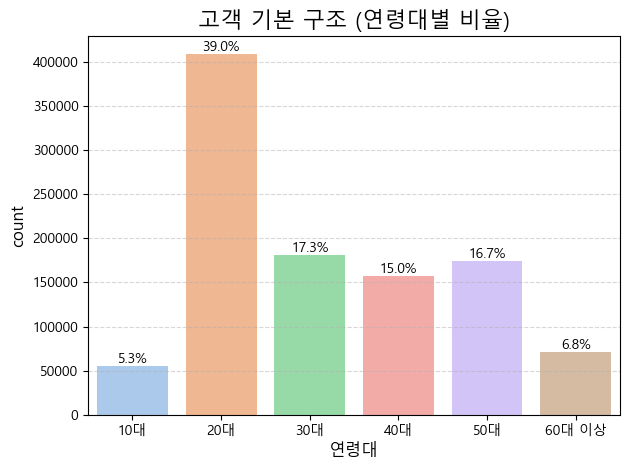

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
age_order = ['10대', '20대', '30대', '40대', '50대', '60대 이상']

age_cnt = df_cust2['age_segment'].value_counts().reindex(age_order)
age_pct = (age_cnt / age_cnt.sum() * 100).round(1)

df_cust2['age_segment'] = pd.Categorical(
    df_cust2['age_segment'],
    categories=age_order,
    ordered=True
)

ax = sns.countplot(
    x='age_segment',
    data=df_cust2,
    order=df_cust2['age_segment'].cat.categories,
    palette='pastel',
    legend=False
)

# 막대 위에 비율 표시
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    if height > 0:
        pct = age_pct.iloc[i]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{pct}%',
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.title('고객 기본 구조 (연령대별 비율)', fontsize=16)
plt.xlabel('연령대', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

customer table 전처리 됐고, 이제 transaction 해보자

In [19]:
df_tran2.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   t_dat             1048575 non-null  str    
 1   customer_id       1048575 non-null  str    
 2   article_id        1048575 non-null  str    
 3   price             1048575 non-null  float64
 4   sales_channel_id  1048575 non-null  int64  
dtypes: float64(1), int64(1), str(3)
memory usage: 40.0 MB


In [20]:
df_tran2.isnull().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [21]:
df_tran2["t_dat"] = pd.to_datetime(df_tran2["t_dat"], format="%Y-%m-%d")

In [22]:
df_tran2.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1048575 non-null  datetime64[us]
 1   customer_id       1048575 non-null  str           
 2   article_id        1048575 non-null  str           
 3   price             1048575 non-null  float64       
 4   sales_channel_id  1048575 non-null  int64         
dtypes: datetime64[us](1), float64(1), int64(1), str(2)
memory usage: 40.0 MB


In [23]:
df_tran2["channel"] = df_tran2["sales_channel_id"].map({1: "Offline", 2: "Online"})

In [24]:
df_tran2["channel"].value_counts()
numbs = df_tran2["channel"].value_counts()
print("온라인:", f"{numbs['Online']:,}")
print("오프라인:", f"{numbs['Offline']:,}")
print("전체 거래 건수:", f"{df_tran2.shape[0]:,}")

온라인: 729,192
오프라인: 319,383
전체 거래 건수: 1,048,575


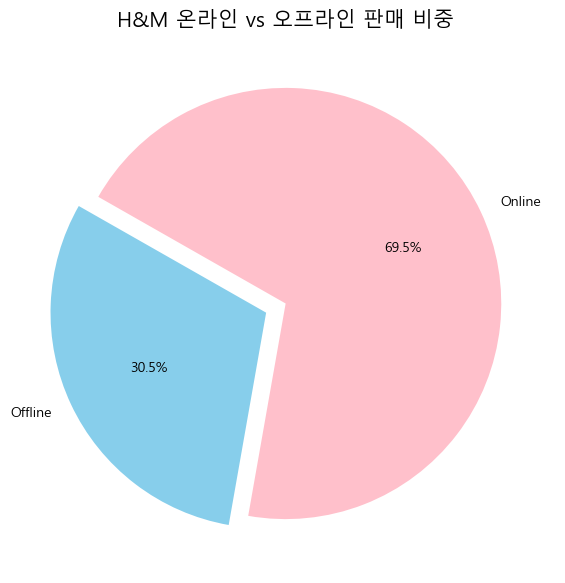

In [25]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows)
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(7, 7))
# 조각 하나 살짝 띄우기
explode = [0, 0.10]
numbs.plot.pie(
    autopct='%.1f%%',          # 퍼센트 표시
    startangle=260,            # 시작 각도
    colors=['pink', 'skyblue'],
    ylabel='',
    explode=explode
)
plt.title("H&M 온라인 vs 오프라인 판매 비중", fontsize=15)
plt.savefig('channel_pie.png', dpi=300)
plt.show()

In [26]:
df_tran2['price'].describe() 
print("price가 0.1 이상:", len(df_tran2[df_tran2["price"] >= 0.1]))
print("price가 0.2 이상:", len(df_tran2[df_tran2["price"] >= 0.2]))
print("price가 0.3 이상:", len(df_tran2[df_tran2["price"] >= 0.3]))
print("price가 0.4 이상:", len(df_tran2[df_tran2["price"] >= 0.4]))
print("price가 0.5 이상:", len(df_tran2[df_tran2["price"] >= 0.5]))


price가 0.1 이상: 10803
price가 0.2 이상: 724
price가 0.3 이상: 127
price가 0.4 이상: 29
price가 0.5 이상: 2


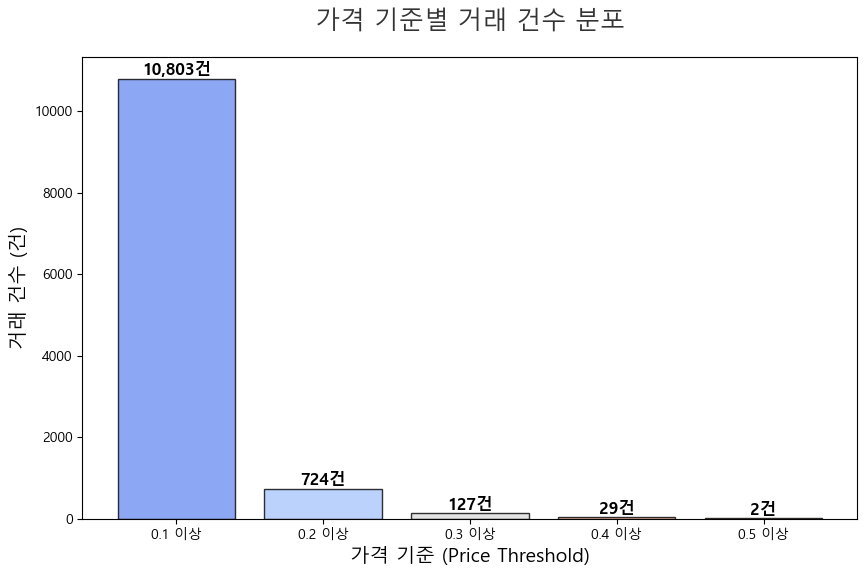

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

labels = ['0.1 이상', '0.2 이상', '0.3 이상', '0.4 이상', '0.5 이상']
counts = [
    len(df_tran[df_tran["price"] >= 0.1]),
    len(df_tran[df_tran["price"] >= 0.2]),
    len(df_tran[df_tran["price"] >= 0.3]),
    len(df_tran[df_tran["price"] >= 0.4]),
    len(df_tran[df_tran["price"] >= 0.5])
]

plt.figure(figsize=(10, 6))
colors = sns.color_palette("coolwarm", len(labels)) # 가격이 올라갈수록 진해지는 색상

bars = plt.bar(labels, counts, color=colors, edgecolor='black', alpha=0.8)

# 막대 위에 실제 거래 건수 표시 (콤마 포함)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}건', ha='center', va='bottom', fontsize=12, fontweight='bold')


plt.title('가격 기준별 거래 건수 분포', fontsize=18, pad=20, color='#333333')
plt.xlabel('가격 기준 (Price Threshold)', fontsize=14)
plt.ylabel('거래 건수 (건)', fontsize=14)

plt.savefig('price_.png', dpi=300)
plt.show()

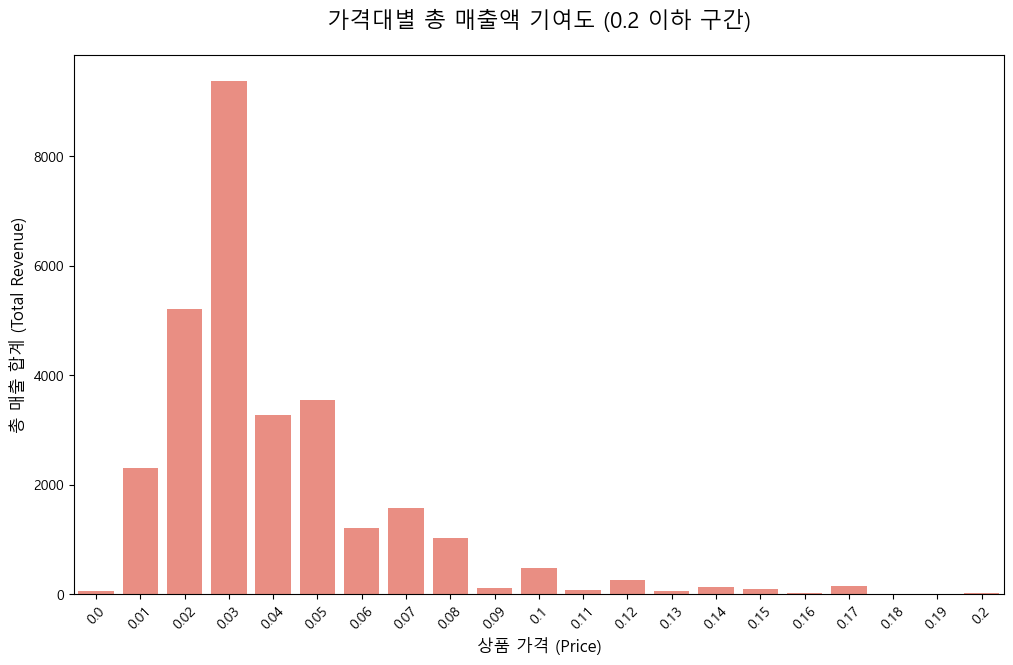

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 가격대를 일정 구간으로 나누어 매출 합계 계산
# 시각화를 위해 0.01 단위로 끊어서 매출 비중을 볼 수 있도록 설정
df_tran['price_group'] = df_tran['price'].round(2) # 가격을 소수점 둘째자리로 반올림
revenue_dist = df_tran.groupby('price_group')['price'].sum().reset_index()

plt.figure(figsize=(12, 7))
sns.barplot(data=revenue_dist[revenue_dist['price_group'] <= 0.2], 
            x='price_group', y='price', color='salmon')

plt.title('가격대별 총 매출액 기여도 (0.2 이하 구간)', fontsize=16, pad=20)
plt.xlabel('상품 가격 (Price)', fontsize=12)
plt.ylabel('총 매출 합계 (Total Revenue)', fontsize=12)
plt.xticks(rotation=45) # 글자가 겹치지 않게 회전
plt.savefig('price_bar_chart.png', dpi=300)
plt.show()

In [29]:
high_price_transactions = df_tran2[df_tran2["price"] >= 0.1]
high_price_transactions['channel'].replace({1: 'Offline', 2: 'Online'}).value_counts()

channel_counts = (
    high_price_transactions['channel']
    .replace({1: 'Offline', 2: 'Online'})
    .value_counts()
)

channel_ratio = channel_counts / channel_counts.sum() * 100

result_df = pd.DataFrame({
    'count': channel_counts,
    'ratio(%)': channel_ratio.round(2)
})

result_df


,count,ratio(%)
channel,,
Online,9875,91.41
Offline,928,8.59


In [30]:
df_tran2['year_month'] = df_tran2['t_dat'].dt.to_period('M')

In [31]:
monthly_sales = df_tran2.groupby('year_month').size() # size()는 count와 다르게 NaN값도 포함해서 계산. 전체 데이터 개수를 보기 위해서!
monthly_price = df_tran2.groupby('year_month')['price'].sum()

print(monthly_price)

year_month
2019-01    2148.279639
2019-02    2006.034201
2019-03    2395.173487
2019-04    2725.229843
2019-05    2768.568961
2019-06    3113.444654
2019-07    2571.945537
2019-08    1960.310828
2019-09    2581.655388
2019-10    2376.303726
2019-11    2482.021880
2019-12    1999.556979
Freq: M, Name: price, dtype: float64


In [32]:
best_month = monthly_price.idxmax()
best_value = monthly_price.max()

print("가장 매출이 높은 달:", best_month)
print("그 달의 매출:", best_value) 

가장 매출이 높은 달: 2019-06
그 달의 매출: 3113.444654044


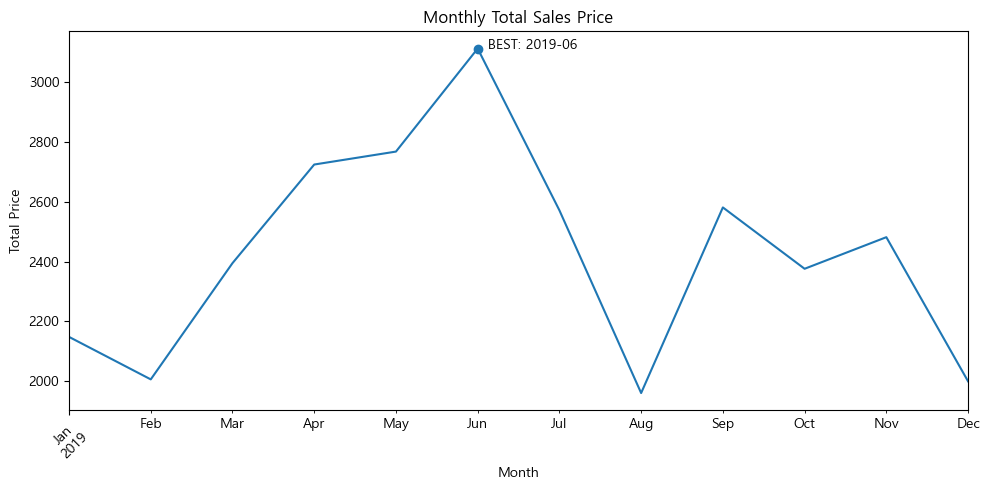

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
monthly_price.plot()

plt.scatter(best_month.to_timestamp(), best_value)
plt.text(best_month.to_timestamp(), best_value, 
         f"  BEST: {best_month}", fontsize=10)

plt.title("Monthly Total Sales Price")
plt.xlabel("Month")
plt.ylabel("Total Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#Y축은 0에서 시작되지 않음을 설명합시다.

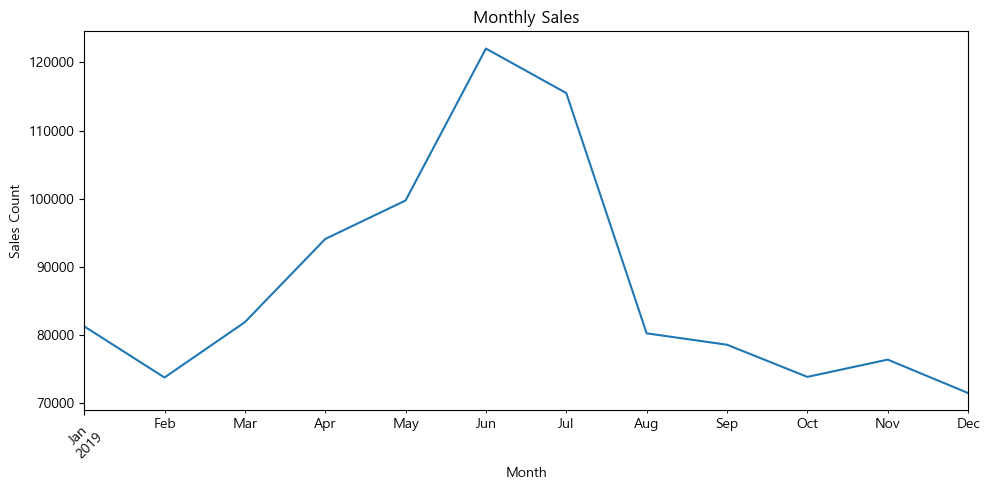

In [34]:
plt.figure(figsize=(10,5))
monthly_sales.plot()
plt.title("Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Sales Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

이제 articles table 전처리 단계

In [35]:
df_art2.info()

<class 'pandas.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   article_id                    105542 non-null  str  
 1   product_code                  105542 non-null  int64
 2   prod_name                     105542 non-null  str  
 3   product_type_no               105542 non-null  int64
 4   product_type_name             105542 non-null  str  
 5   product_group_name            105542 non-null  str  
 6   graphical_appearance_no       105542 non-null  int64
 7   graphical_appearance_name     105542 non-null  str  
 8   colour_group_code             105542 non-null  int64
 9   colour_group_name             105542 non-null  str  
 10  perceived_colour_value_id     105542 non-null  int64
 11  perceived_colour_value_name   105542 non-null  str  
 12  perceived_colour_master_id    105542 non-null  int64
 13  perceived_colour_master_n

In [36]:
df_art2.isnull().sum() 

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [37]:
df_art2["detail_desc"] = df_art2["detail_desc"].fillna("No description")
#제품 상세 설명란에 아무런 설명이 없음으로 결측치를 'No description'으로 대체

In [38]:
df_art2.isnull().sum()

article_id                      0
product_code                    0
prod_name                       0
product_type_no                 0
product_type_name               0
product_group_name              0
graphical_appearance_no         0
graphical_appearance_name       0
colour_group_code               0
colour_group_name               0
perceived_colour_value_id       0
perceived_colour_value_name     0
perceived_colour_master_id      0
perceived_colour_master_name    0
department_no                   0
department_name                 0
index_code                      0
index_name                      0
index_group_no                  0
index_group_name                0
section_no                      0
section_name                    0
garment_group_no                0
garment_group_name              0
detail_desc                     0
dtype: int64

In [39]:
df_art2['detail_desc'].value_counts().head()

detail_desc
No description                                                        416
T-shirt in printed cotton jersey.                                     159
Leggings in soft organic cotton jersey with an elasticated waist.     138
T-shirt in soft, printed cotton jersey.                               137
Socks in a soft, jacquard-knit cotton blend with elasticated tops.    136
Name: count, dtype: int64

In [40]:
cols_to_drop = [
    'product_type_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no'
]
df_art_cleaned = df_art2.drop(columns=cols_to_drop) 

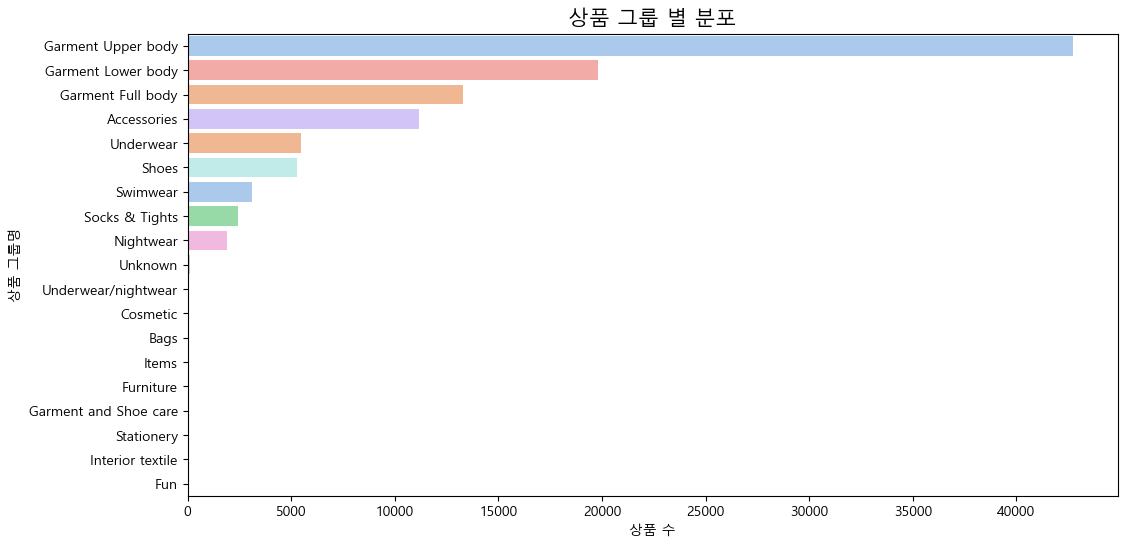

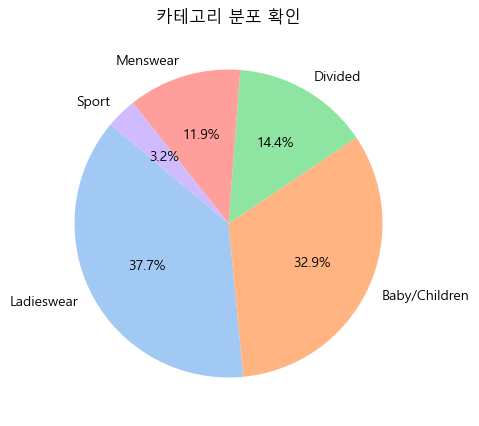

In [41]:
## [articles] EDA 시각화

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 1. product_group_name(상품 그룹) 분포 확인 (가로형 막대그래프), 내림차순
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_art_cleaned, 
    y='product_group_name', 
    order=df_art_cleaned['product_group_name'].value_counts().index,
    hue='product_group_name',    #개선점 말해줘서 변경
    palette='pastel',
    legend=False    #범례는 안 넣을 것
)
plt.title('상품 그룹 별 분포', fontsize=15)  
plt.xlabel('상품 수')
plt.ylabel('상품 그룹명')
plt.show()

# 2. 카테고리 분포 확인
plt.figure(figsize=(5, 5))
df_art_cleaned['index_group_name'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel'),
    ylabel=''   #ylabel False로 설정(위치변경)
)
plt.title('카테고리 분포 확인')
plt.show()

In [42]:
def get_season(row):
    # section_name과 prod_name을 합쳐서 판단
    text = (str(row['section_name']) + " " + str(row['prod_name'])).lower()
    group = str(row['product_group_name']).lower()
    
    # 1. SS
    ss_keywords = [
        'swimwear', 'sport', 'shorts', 'sandals', 'sleeveless', 
        'tank', 'mini', 'beach', 'summer', 'sun', 'flip flop', 
        'skirt', 'dress'
    ]

    # 2. FW 
    fw_keywords = [
        'outerwear', 'knitted', 
        'jacket', 'coat', 'hoodie', 'sweatshirt', 'scarf', 'gloves', 
        'boots', 'heavy', 'fur', 'wool', 'cardigan', 'winter'
    ]
    
    if any(kw in text for kw in ss_keywords) or group in ['swimwear']:
        return 'SS'
    # FW는 오직 두꺼운 옷 키워드가 있을 때만! (items of clothing 조건 제거)
    elif any(kw in text for kw in fw_keywords):
        return 'FW'
    else:
        return 'All-Season'

In [43]:
#파생변수 생성 및 이름만 조금 더 직관적으로 분류
df_art_cleaned['product_season'] = df_art_cleaned.apply(get_season, axis=1)
df_art_cleaned['category_main'] = df_art_cleaned['index_group_name']
#원본 보존하고 복사해서 이름 변경 (메인 카테고리 정의)

In [44]:
def get_color_tone(color):
    color = str(color).lower()
    dark_colors = ['black', 'dark blue', 'dark grey', 'dark red', 'dark pink', 'dark purple', 'dark green', 'dark orange', 'dark beige', 'dark turquoise', 'dark yellow', 'grey', 'bronze/copper']
    light_colors = ['white', 'off white', 'light beige', 'light blue', 'light grey', 'light orange', 'light pink', 'light green', 'light red', 'light yellow', 'light purple', 'transparent', 'light turquoise']
    
    if any(dc in color for dc in dark_colors):
        return 'Dark_Tone'
    elif any(lc in color for lc in light_colors):
        return 'Light_Tone'
    else:
        return 'Neutral_Tone'

df_art_cleaned['color_tone'] = df_art_cleaned['colour_group_name'].apply(get_color_tone)

In [45]:
#톤 검증
print(df_art_cleaned['colour_group_name'].unique())
print("---------------")
print(df_art_cleaned['section_name'].unique())
#시즌 검증
print(df_art_cleaned['product_season'].unique())
print(df_art_cleaned[df_art_cleaned['product_season'] == 'FW']['prod_name'].unique())
print("\n------------")
print(df_art_cleaned[df_art_cleaned['product_season'] == 'SS']['prod_name'].unique())
print("\n------------")
print(df_art_cleaned[df_art_cleaned['product_season'] == 'All-Season']['prod_name'].unique())

<StringArray>
[          'Black',           'White',       'Off White',     'Light Beige',
           'Beige',            'Grey',      'Light Blue',      'Light Grey',
       'Dark Blue',       'Dark Grey',            'Pink',        'Dark Red',
   'Greyish Beige',    'Light Orange',          'Silver',            'Gold',
      'Light Pink',       'Dark Pink', 'Yellowish Brown',            'Blue',
 'Light Turquoise',          'Yellow',  'Greenish Khaki',     'Dark Yellow',
      'Other Pink',     'Dark Purple',             'Red',     'Transparent',
      'Dark Green',       'Other Red',       'Turquoise',     'Dark Orange',
           'Other',          'Orange',      'Dark Beige',    'Other Yellow',
     'Light Green',    'Other Orange',          'Purple',       'Light Red',
    'Light Yellow',           'Green',    'Light Purple',  'Dark Turquoise',
    'Other Purple',   'Bronze/Copper', 'Other Turquoise',     'Other Green',
      'Other Blue',         'Unknown']
Length: 50, dtype: str


Join 슛

In [46]:
#  거래 + 고객 (customer_id 기준)
merged_df = pd.merge(df_tran2, df_cust2, on='customer_id', how='left')
final_df = pd.merge(merged_df, df_art_cleaned, on='article_id', how='left')

In [47]:
# 결과 확인
print(df_tran2.shape)
print(final_df.shape)
final_df.head()

(1048575, 7)
(1048575, 31)


,t_dat,customer_id,article_id,price,sales_channel_id,channel,year_month,FN,Active,club_member_status,...,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,product_season,category_main,color_tone
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,0698328010,0.016932,2,Online,2019-11,1.0,1.0,ACTIVE,...,Blue,Tops Fancy Jersey,Divided,Divided,Divided Collection,Jersey Fancy,Top in lightweight sweatshirt fabric with drop...,All-Season,Divided,Dark_Tone
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,0760597002,0.033881,2,Online,2019-05,0.0,0.0,ACTIVE,...,White,Jersey,Ladieswear,Ladieswear,Womens Casual,Jersey Fancy,"Short-sleeved blouse in stretch, textured jers...",All-Season,Ladieswear,Light_Tone
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,0488561032,0.016932,2,Online,2019-05,1.0,1.0,ACTIVE,...,Blue,Shorts,Menswear,Menswear,Contemporary Casual,Shorts,Knee-length shorts in soft washed cotton with ...,All-Season,Menswear,Dark_Tone
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,0682771001,0.033881,2,Online,2019-08,0.0,0.0,ACTIVE,...,Black,Bags,Ladies Accessories,Ladieswear,Womens Big accessories,Accessories,Shopper in grained imitation leather with two ...,All-Season,Ladieswear,Dark_Tone
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,0742400033,0.003220,1,Offline,2019-08,0.0,0.0,ACTIVE,...,White,Socks Wall,Menswear,Menswear,Men Underwear,Socks and Tights,"Socks in a soft, fine-knit cotton blend with r...",SS,Menswear,Light_Tone


In [48]:
merged_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   t_dat                   1048575 non-null  datetime64[us]
 1   customer_id             1048575 non-null  str           
 2   article_id              1048575 non-null  str           
 3   price                   1048575 non-null  float64       
 4   sales_channel_id        1048575 non-null  int64         
 5   channel                 1048575 non-null  str           
 6   year_month              1048575 non-null  period[M]     
 7   FN                      812931 non-null   float64       
 8   Active                  812931 non-null   float64       
 9   club_member_status      812931 non-null   str           
 10  fashion_news_frequency  812931 non-null   str           
 11  age                     812931 non-null   float64       
 12  age_group               8

In [49]:
final_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 31 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   t_dat                         1048575 non-null  datetime64[us]
 1   customer_id                   1048575 non-null  str           
 2   article_id                    1048575 non-null  str           
 3   price                         1048575 non-null  float64       
 4   sales_channel_id              1048575 non-null  int64         
 5   channel                       1048575 non-null  str           
 6   year_month                    1048575 non-null  period[M]     
 7   FN                            812931 non-null   float64       
 8   Active                        812931 non-null   float64       
 9   club_member_status            812931 non-null   str           
 10  fashion_news_frequency        812931 non-null   str           
 11  age      

In [50]:
merged_df.describe()   

,t_dat,price,sales_channel_id,FN,Active,age,age_group
count,1048575,1.048575e+06,1.048575e+06,812931.000000,812931.000000,812931.000000,812931.000000
mean,2019-06-27 12:01:40.730991,2.777915e-02,1.695412e+00,0.433205,0.427052,36.363022,31.971643
min,2019-01-01 00:00:00,2.372880e-04,1.000000e+00,0.000000,0.000000,16.000000,10.000000
25%,2019-04-08 00:00:00,1.523729e-02,1.000000e+00,0.000000,0.000000,26.000000,20.000000
50%,2019-06-25 00:00:00,2.540678e-02,2.000000e+00,0.000000,0.000000,32.000000,30.000000
75%,2019-09-17 00:00:00,3.388136e-02,2.000000e+00,1.000000,1.000000,48.000000,40.000000
max,2019-12-31 00:00:00,5.067797e-01,2.000000e+00,1.000000,1.000000,99.000000,90.000000
std,NaN,1.935764e-02,4.602328e-01,0.495519,0.494650,13.007296,13.200541


In [51]:
merged_df.duplicated().sum()

np.int64(8474)

In [52]:
merged_df.isnull().sum()

t_dat                          0
customer_id                    0
article_id                     0
price                          0
sales_channel_id               0
channel                        0
year_month                     0
FN                        235644
Active                    235644
club_member_status        235644
fashion_news_frequency    235644
age                       235644
age_group                 235644
age_segment               235644
dtype: int64

In [53]:
cat_cols = [
    'FN', 'Active', 'club_member_status', 
    'fashion_news_frequency', 'age_segment'
]

final_df[cat_cols] = final_df[cat_cols].astype('object').fillna('Unknown')
final_df[cat_cols].isnull().sum()

FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age_segment               0
dtype: int64

In [54]:
final_df['age_segment'].value_counts(normalize=True)

age_segment
20대        0.316840
Unknown    0.224728
30대        0.158149
50대        0.129976
40대        0.120895
60대 이상     0.036298
10대        0.013114
Name: proportion, dtype: float64

In [55]:
cat_cols = [
    'FN', 'Active', 'club_member_status', 
    'fashion_news_frequency', 'age_segment'
]

final_df[cat_cols] = final_df[cat_cols].astype('object').fillna('Unknown')
final_df[cat_cols].isnull().sum()

FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age_segment               0
dtype: int64

In [56]:
final_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 31 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   t_dat                         1048575 non-null  datetime64[us]
 1   customer_id                   1048575 non-null  str           
 2   article_id                    1048575 non-null  str           
 3   price                         1048575 non-null  float64       
 4   sales_channel_id              1048575 non-null  int64         
 5   channel                       1048575 non-null  str           
 6   year_month                    1048575 non-null  period[M]     
 7   FN                            1048575 non-null  object        
 8   Active                        1048575 non-null  object        
 9   club_member_status            1048575 non-null  object        
 10  fashion_news_frequency        1048575 non-null  object        
 11  age      

In [57]:
online_df = merged_df[merged_df['channel'] == 'Online']
offline_df = merged_df[merged_df['channel'] == 'Offline']

In [58]:
online_monthly_price = online_df.groupby('year_month')['price'].sum()
offline_monthly_price = offline_df.groupby('year_month')['price'].sum()

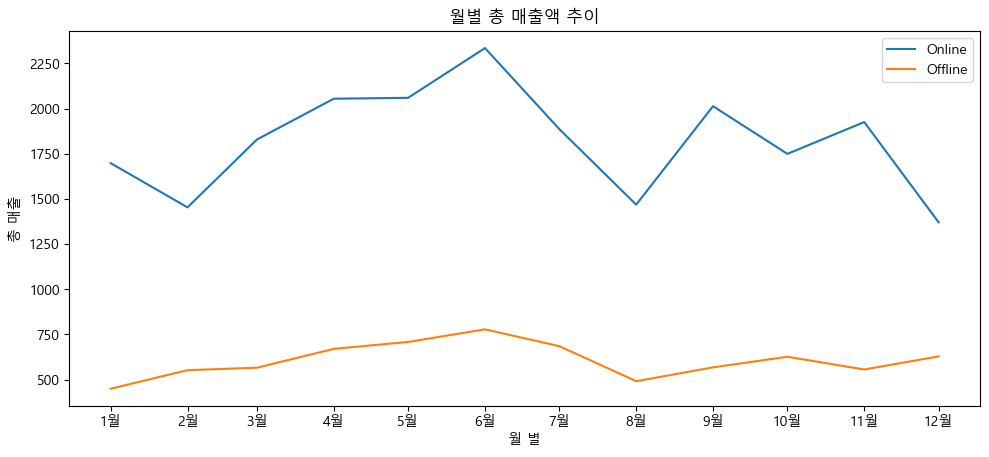

In [79]:
plt.figure(figsize=(10,5))

plt.plot(online_monthly_price.index.to_timestamp(), online_monthly_price.values, label='Online')
plt.plot(offline_monthly_price.index.to_timestamp(), offline_monthly_price.values, label='Offline')

plt.title("월별 총 매출액 추이")
plt.xlabel("월 별")
plt.ylabel("총 매출")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.xticks(online_monthly_price.index.to_timestamp(), 
        [f"{m}월" for m in range(1, 13)], 
        rotation=0)
plt.show()

In [60]:
# 1. 원하는 출력 순서 정의 (10대부터 Unknown까지)
ordered_index = ['10대', '20대', '30대', '40대', '50대', '60대 이상', 'Unknown']

# 2. 정해진 순서대로 다시 집계 (reindex 사용)
# 이전에 실행한 결과가 섞여 있어도, 이 코드가 순서를 강제로 맞춰줌
age_summary_ordered = final_df['age_segment'].value_counts().reindex(ordered_index)

print("### 연령대별 고객 분포 (정해진 순서대로) ###")
print(age_summary_ordered)

### 연령대별 고객 분포 (정해진 순서대로) ###
age_segment
10대         13751
20대        332231
30대        165831
40대        126767
50대        136290
60대 이상      38061
Unknown    235644
Name: count, dtype: int64


In [61]:
# 1. 연령대별 매출 합계(sum)와 평균(mean) 계산
age_price_analysis = final_df.groupby('age_segment')['price'].agg(['sum', 'mean'])

# 2. 정한 순서대로 정렬 
ordered_index = ['10대', '20대', '30대', '40대', '50대', '60대 이상', 'Unknown']
age_price_analysis = age_price_analysis.loc[ordered_index]


age_price_analysis.columns = ['총 매출액', '평균 객단가']

print("### 연령대별 매출 성과 분석 ###")
age_price_analysis.round(4)

### 연령대별 매출 성과 분석 ###


,총 매출액,평균 객단가
age_segment,,
10대,325.1327,0.0236
20대,8999.9204,0.0271
30대,4638.4555,0.0280
40대,3481.6867,0.0275
50대,3975.9159,0.0292
60대 이상,1157.5371,0.0304
Unknown,6549.8768,0.0278


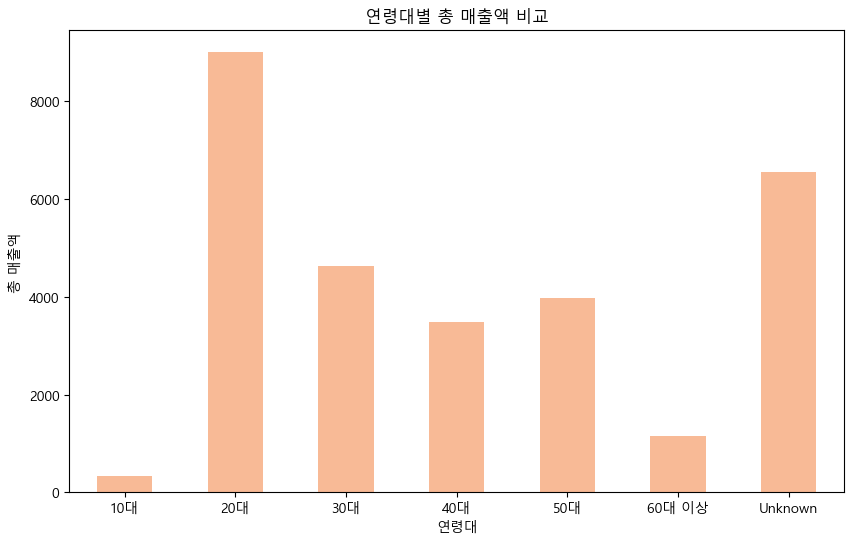

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.rc('font', family='Malgun Gothic')

plt.figure(figsize=(10, 6))
age_price_analysis['총 매출액'].plot(kind='bar', color='#f8ba96')


plt.title('연령대별 총 매출액 비교')
plt.xlabel('연령대')
plt.ylabel('총 매출액')
plt.xticks(rotation=0) # 글자 똑바로 세우기

plt.show()

In [63]:
# groupby를 이용해 연령대별, 채널별 거래 건수 집계
# unstack()을 하면 채널 번호(1, 2)가 컬럼으로 올라오게됨
channel_counts = final_df.groupby(['age_segment', 'sales_channel_id']).size().unstack(fill_value=0)

channel_counts = channel_counts.rename(columns={1: 'Offline(1)', 2: 'Online(2)'})

ordered_index = ['10대', '20대', '30대', '40대', '50대', '60대 이상', 'Unknown']
channel_counts = channel_counts.loc[ordered_index]

# 4. 비중(%) 계산: 각 연령대 내에서 온/오프라인이 차지하는 비율
channel_perc = channel_counts.div(channel_counts.sum(axis=1), axis=0) * 100

print("### 연령대별 온/오프라인 이용 비중 (%) ###")
channel_perc.round(1)

### 연령대별 온/오프라인 이용 비중 (%) ###


sales_channel_id,Offline(1),Online(2)
age_segment,,
10대,41.9,58.1
20대,29.8,70.2
30대,24.9,75.1
40대,33.1,66.9
50대,33.7,66.3
60대 이상,35.8,64.2
Unknown,30.5,69.5


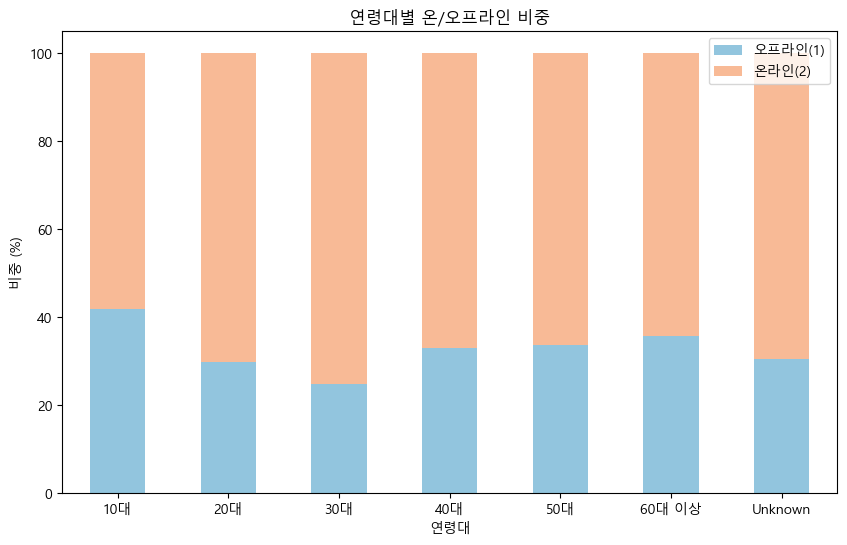

In [75]:
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')

channel_perc.plot(kind='bar', stacked=True, color=['#92c5de', "#f8ba96"], figsize=(10, 6))


plt.title('연령대별 온/오프라인 비중')
plt.xlabel('연령대')
plt.ylabel('비중 (%)')
plt.legend(title=None, labels=['오프라인(1)', '온라인(2)'])
plt.xticks(rotation=0)
plt.show()

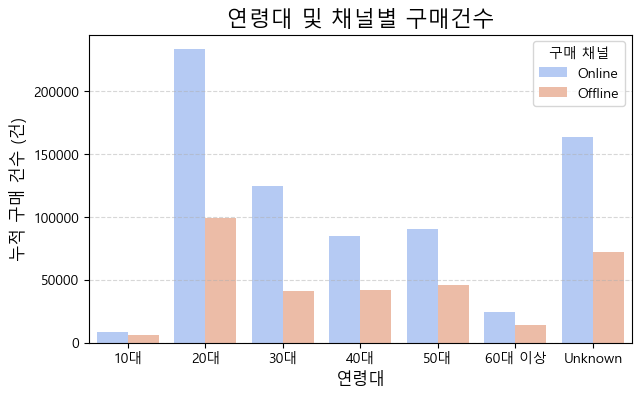

In [65]:
##연령대 및 채널별 구매건수
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 4))

sns.countplot(
    data=final_df, 
    x='age_segment', 
    hue='channel', 
    order=['10대', '20대', '30대', '40대', '50대', '60대 이상', 'Unknown'],
    palette='coolwarm'
)

plt.title('연령대 및 채널별 구매건수', fontsize=16)
plt.xlabel('연령대', fontsize=12)
plt.ylabel('누적 구매 건수 (건)', fontsize=12)
plt.legend(title='구매 채널')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

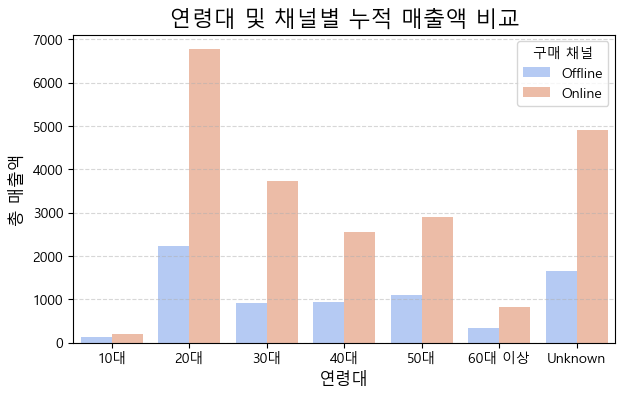

In [66]:
## 연령대 및 채널별 누적 매출액
df_sales = final_df.groupby(['age_segment', 'channel'])['price'].sum().reset_index()

plt.figure(figsize=(7, 4))
sns.barplot(
    data=df_sales, 
    x='age_segment', 
    y='price', 
    hue='channel',
    palette='coolwarm',
    order=['10대', '20대', '30대', '40대', '50대', '60대 이상', 'Unknown']
)

plt.title('연령대 및 채널별 누적 매출액 비교', fontsize=16)
plt.xlabel('연령대', fontsize=12)
plt.ylabel('총 매출액', fontsize=12)
plt.legend(title='구매 채널')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()